In [ ]:
# Used to dowload best model from colab 
from google.colab import files
files.download('best_sign_lang_finetuned.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Can be used to download the data
!pip install megatools
!megadl 'https://mega.nz/file/FLITlD7C#GbU0J0Yc3v9GLYKDm4os_a2-Ib9YTnBf5vwLSi4iC08' --path sign_lang_train.zip

In [ ]:
# Used to unzip data in colab and save it 'my_data/', make sure to have the zip first
!unzip /content/sign_lang_train.zip -d /my_data/

# 0. Imports

In [ ]:
import os
import csv
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet152V2, EfficientNetB3
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## 1. Data Loading

In [ ]:
csv_path = '/my_data/sign_lang_train/labels.csv'             
all_pairs = []
with open(csv_path, newline='') as f:
    for label, fname in csv.reader(f):
        all_pairs.append((label, fname))

random.seed(42)
random.shuffle(all_pairs)
N = len(all_pairs)
n_train = int(0.7 * N)
n_val   = int(0.15 * N)

train_pairs = all_pairs[:n_train]
val_pairs   = all_pairs[n_train:n_train+n_val]
test_pairs  = all_pairs[n_train+n_val:]

print(f"Total {N} images → train {len(train_pairs)}, val {len(val_pairs)}, test {len(test_pairs)}")

Total 9680 images → train 6776, val 1452, test 1452


## 2. Improved preprocessing and augmentation

In [ ]:
DATA_ROOT = '/my_data/sign_lang_train/'
class_names = list(map(str, range(10))) + list('abcdefghijklmnopqrstuvwxyz')
NUM_CLASSES = len(class_names)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
AUTOTUNE = tf.data.AUTOTUNE

rotation_layer = tf.keras.layers.RandomRotation(factor=0.2)


def parse_image_train(file_path, label):
    label = tf.cast(label, tf.int32)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
    img = tf.cast(img, tf.float32) / 255.0

    # Data augmentation for training
    img = tf.image.random_flip_left_right(img)

    return img, label

def parse_image_val(file_path, label):
    label = tf.cast(label, tf.int32)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


sample_file = train_files[0]
sample_label = train_labels[0]

print(f"Testing parse_image_train with file: {sample_file}, label: {sample_label}")
try:
    parsed_image, parsed_label = parse_image_train(sample_file, sample_label)
    print(f"Parsed Image Shape: {parsed_image.shape}, Dtype: {parsed_image.dtype}")
    print(f"Parsed Label: {parsed_label.numpy()}, Dtype: {parsed_label.dtype}")
except Exception as e:
    print(f"Error during parse_image_train: {e}")

def make_lists(pairs):
    filepaths = [os.path.join(DATA_ROOT, fname) for label, fname in pairs]
    labels    = [class_names.index(label)        for label, fname in pairs]
    return filepaths, labels

train_files, train_labels = make_lists(train_pairs)
val_files,   val_labels   = make_lists(val_pairs)
test_files,  test_labels  = make_lists(test_pairs)


Testing parse_image_train with file: /my_data/sign_lang_train/FWJNITXLZAAMBCPE.jpg, label: 13
Parsed Image Shape: (224, 224, 3), Dtype: <dtype: 'float32'>
Parsed Label: 13, Dtype: <dtype: 'int32'>


## 3. Enhanced data pipeline

In [ ]:
def make_train_ds(files, labels):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(parse_image_train, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(10 * BATCH_SIZE, seed=42)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(tf.data.AUTOTUNE)

def make_val_ds(files, labels):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    ds = ds.map(parse_image_val, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(AUTOTUNE)

train_ds = make_train_ds(train_files, train_labels)
val_ds   = make_val_ds(val_files, val_labels)
test_ds  = make_val_ds(test_files, test_labels)


In [ ]:
sample_file = train_files[0]
sample_label = train_labels[0]

print(f"Testing parse_image_train with file: {sample_file}, label: {sample_label}")
try:
    parsed_image, parsed_label = parse_image_train(sample_file, sample_label)
    print(f"Parsed Image Shape: {parsed_image.shape}, Dtype: {parsed_image.dtype}")
    print(f"Parsed Label: {parsed_label}, Dtype: {parsed_label.dtype}")
except Exception as e:
    print(f"Error during parse_image_train: {e}")

Testing parse_image_train with file: /my_data/sign_lang_train/FWJNITXLZAAMBCPE.jpg, label: 13
Parsed Image Shape: (224, 224, 3), Dtype: <dtype: 'float32'>
Parsed Label: 13, Dtype: <dtype: 'int32'>


## 4. Improved model architecture with fine-tuning strategy

In [ ]:
def create_model(num_classes, input_shape):
    # We can use ResNet152V2 or try EfficientNetB3
    base = ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    base.trainable = False

    model = models.Sequential([
        base,
        layers.BatchNormalization(),
        layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base

model, base_model = create_model(NUM_CLASSES, IMG_SIZE + (3,))

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_205         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,103,396 (233.09 MB)

 Trainable params: 2,767,652 (10.56 MB)

 Non-trainable params: 58,335,744 (222.53 MB)

## 5. Callbacks

In [ ]:
callbacks = [
    ModelCheckpoint(
        'best_sign_lang_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

## 6. Two-stage training: Transfer learning + Fine-tuning

In [ ]:
print("Stage 1: Training with frozen base model...")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

print("\nStage 2: Fine-tuning with unfrozen layers...")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards (last few layers)
fine_tune_at = len(base_model.layers) - 20

# Freeze earlier layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks[0] = ModelCheckpoint(
    'best_sign_lang_finetuned.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Stage 1: Training with frozen base model...
Epoch 1/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.0847 - loss: 26.4112 - top_3_accuracy: 0.2000
Epoch 1: val_accuracy improved from -inf to 0.35882, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 114s 387ms/step - accuracy: 0.0850 - loss: 26.4048 - top_3_accuracy: 0.2004 - val_accuracy: 0.3588 - val_loss: 22.6031 - val_top_3_accuracy: 0.5744 - learning_rate: 1.0000e-04
Epoch 2/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.3054 - loss: 21.6554 - top_3_accuracy: 0.5247
Epoch 2: val_accuracy improved from 0.35882 to 0.47865, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 103s 261ms/step - accuracy: 0.3055 - loss: 21.6511 - top_3_accuracy: 0.5249 - val_accuracy: 0.4787 - val_loss: 18.7838 - val_top_3_accuracy: 0.7018 - learning_rate: 1.0000e-04
Epoch 3/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4250 - loss: 18.1895 - top_3_accuracy: 0.6642
Epoch 3: val_accuracy improved from 0.47865 to 0.56061, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 57s 267ms/step - accuracy: 0.4251 - loss: 18.1861 - top_3_accuracy: 0.6643 - val_accuracy: 0.5606 - val_loss: 15.8753 - val_top_3_accuracy: 0.7686 - learning_rate: 1.0000e-04
Epoch 4/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4951 - loss: 15.4790 - top_3_accuracy: 0.7329
Epoch 4: val_accuracy improved from 0.56061 to 0.60124, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 251ms/step - accuracy: 0.4952 - loss: 15.4762 - top_3_accuracy: 0.7330 - val_accuracy: 0.6012 - val_loss: 13.5566 - val_top_3_accuracy: 0.8106 - learning_rate: 1.0000e-04
Epoch 5/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5433 - loss: 13.2178 - top_3_accuracy: 0.7881
Epoch 5: val_accuracy improved from 0.60124 to 0.63636, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 51s 240ms/step - accuracy: 0.5433 - loss: 13.2156 - top_3_accuracy: 0.7881 - val_accuracy: 0.6364 - val_loss: 11.6490 - val_top_3_accuracy: 0.8299 - learning_rate: 1.0000e-04
Epoch 6/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5965 - loss: 11.3314 - top_3_accuracy: 0.8283
Epoch 6: val_accuracy improved from 0.63636 to 0.65014, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 53s 247ms/step - accuracy: 0.5965 - loss: 11.3296 - top_3_accuracy: 0.8283 - val_accuracy: 0.6501 - val_loss: 10.0463 - val_top_3_accuracy: 0.8492 - learning_rate: 1.0000e-04
Epoch 7/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6226 - loss: 9.7599 - top_3_accuracy: 0.8590
Epoch 7: val_accuracy improved from 0.65014 to 0.65634, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 270ms/step - accuracy: 0.6226 - loss: 9.7582 - top_3_accuracy: 0.8590 - val_accuracy: 0.6563 - val_loss: 8.6884 - val_top_3_accuracy: 0.8698 - learning_rate: 1.0000e-04
Epoch 8/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6641 - loss: 8.4164 - top_3_accuracy: 0.8763
Epoch 8: val_accuracy improved from 0.65634 to 0.66873, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 260ms/step - accuracy: 0.6641 - loss: 8.4150 - top_3_accuracy: 0.8763 - val_accuracy: 0.6687 - val_loss: 7.5543 - val_top_3_accuracy: 0.8795 - learning_rate: 1.0000e-04
Epoch 9/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.6716 - loss: 7.2936 - top_3_accuracy: 0.8932
Epoch 9: val_accuracy improved from 0.66873 to 0.68457, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 57s 267ms/step - accuracy: 0.6716 - loss: 7.2924 - top_3_accuracy: 0.8932 - val_accuracy: 0.6846 - val_loss: 6.5870 - val_top_3_accuracy: 0.8850 - learning_rate: 1.0000e-04
Epoch 10/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7040 - loss: 6.3227 - top_3_accuracy: 0.9043
Epoch 10: val_accuracy improved from 0.68457 to 0.69215, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 80s 256ms/step - accuracy: 0.7040 - loss: 6.3217 - top_3_accuracy: 0.9043 - val_accuracy: 0.6921 - val_loss: 5.7656 - val_top_3_accuracy: 0.8967 - learning_rate: 1.0000e-04
Epoch 11/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7259 - loss: 5.4951 - top_3_accuracy: 0.9191
Epoch 11: val_accuracy improved from 0.69215 to 0.70179, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 56s 264ms/step - accuracy: 0.7259 - loss: 5.4942 - top_3_accuracy: 0.9192 - val_accuracy: 0.7018 - val_loss: 5.0868 - val_top_3_accuracy: 0.8939 - learning_rate: 1.0000e-04
Epoch 12/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7362 - loss: 4.8238 - top_3_accuracy: 0.9353
Epoch 12: val_accuracy did not improve from 0.70179
212/212 ━━━━━━━━━━━━━━━━━━━━ 77s 242ms/step - accuracy: 0.7362 - loss: 4.8231 - top_3_accuracy: 0.9353 - val_accuracy: 0.7018 - val_loss: 4.5076 - val_top_3_accuracy: 0.9001 - learning_rate: 1.0000e-04
Epoch 13/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7484 - loss: 4.2350 - top_3_accuracy: 0.9373
Epoch 13: val_accuracy improved from 0.70179 to 0.70937, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 90s 278ms/step - accuracy: 0.7484 - loss: 4.2345 - top_3_accuracy: 0.9373 - val_accuracy: 0.7094 - val_loss: 4.0317 - val_top_3_accuracy: 0.9043 - learning_rate: 1.0000e-04
Epoch 14/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7578 - loss: 3.7784 - top_3_accuracy: 0.9437
Epoch 14: val_accuracy did not improve from 0.70937
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 235ms/step - accuracy: 0.7578 - loss: 3.7778 - top_3_accuracy: 0.9437 - val_accuracy: 0.7066 - val_loss: 3.6295 - val_top_3_accuracy: 0.9056 - learning_rate: 1.0000e-04
Epoch 15/15
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7734 - loss: 3.3648 - top_3_accuracy: 0.9467
Epoch 15: val_accuracy improved from 0.70937 to 0.72383, saving model to best_sign_lang_model.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 57s 269ms/step - accuracy: 0.7734 - loss: 3.3644 - top_3_accuracy: 0.9467 - val_accuracy: 0.7238 - val_loss: 3.2896 - val_top_3_accuracy: 0.9077 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.

Stage 2: Fine-tuning with unfrozen layers...
Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.7206 - loss: 3.2495
Epoch 1: val_accuracy improved from -inf to 0.73003, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 122s 419ms/step - accuracy: 0.7207 - loss: 3.2491 - val_accuracy: 0.7300 - val_loss: 3.1965 - learning_rate: 1.0000e-05
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7951 - loss: 2.9964
Epoch 2: val_accuracy improved from 0.73003 to 0.74449, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 63s 295ms/step - accuracy: 0.7951 - loss: 2.9964 - val_accuracy: 0.7445 - val_loss: 3.0937 - learning_rate: 1.0000e-05
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8264 - loss: 2.8738
Epoch 3: val_accuracy improved from 0.74449 to 0.75482, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 63s 296ms/step - accuracy: 0.8264 - loss: 2.8736 - val_accuracy: 0.7548 - val_loss: 3.0167 - learning_rate: 1.0000e-05
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8467 - loss: 2.7564
Epoch 4: val_accuracy improved from 0.75482 to 0.76102, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 59s 276ms/step - accuracy: 0.8467 - loss: 2.7563 - val_accuracy: 0.7610 - val_loss: 2.9498 - learning_rate: 1.0000e-05
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8637 - loss: 2.6659
Epoch 5: val_accuracy improved from 0.76102 to 0.76860, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 61s 284ms/step - accuracy: 0.8638 - loss: 2.6658 - val_accuracy: 0.7686 - val_loss: 2.8897 - learning_rate: 1.0000e-05
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8862 - loss: 2.5666
Epoch 6: val_accuracy improved from 0.76860 to 0.77410, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 303ms/step - accuracy: 0.8862 - loss: 2.5666 - val_accuracy: 0.7741 - val_loss: 2.8152 - learning_rate: 1.0000e-05
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8920 - loss: 2.4979
Epoch 7: val_accuracy improved from 0.77410 to 0.77961, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 63s 297ms/step - accuracy: 0.8920 - loss: 2.4978 - val_accuracy: 0.7796 - val_loss: 2.7603 - learning_rate: 1.0000e-05
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9071 - loss: 2.4126
Epoch 8: val_accuracy improved from 0.77961 to 0.78099, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 86s 318ms/step - accuracy: 0.9071 - loss: 2.4125 - val_accuracy: 0.7810 - val_loss: 2.7041 - learning_rate: 1.0000e-05
Epoch 9/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9171 - loss: 2.3446
Epoch 9: val_accuracy improved from 0.78099 to 0.78375, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 62s 292ms/step - accuracy: 0.9171 - loss: 2.3445 - val_accuracy: 0.7837 - val_loss: 2.6449 - learning_rate: 1.0000e-05
Epoch 10/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9213 - loss: 2.2776
Epoch 10: val_accuracy improved from 0.78375 to 0.78581, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 87s 318ms/step - accuracy: 0.9213 - loss: 2.2775 - val_accuracy: 0.7858 - val_loss: 2.5891 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.
Epoch 1/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9296 - loss: 2.2051
Epoch 1: val_accuracy improved from -inf to 0.79201, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 120s 421ms/step - accuracy: 0.9296 - loss: 2.2050 - val_accuracy: 0.7920 - val_loss: 2.5132 - learning_rate: 1.0000e-05
Epoch 2/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9328 - loss: 2.1311
Epoch 2: val_accuracy did not improve from 0.79201
212/212 ━━━━━━━━━━━━━━━━━━━━ 98s 263ms/step - accuracy: 0.9327 - loss: 2.1310 - val_accuracy: 0.7879 - val_loss: 2.4570 - learning_rate: 1.0000e-05
Epoch 3/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9468 - loss: 2.0399
Epoch 3: val_accuracy improved from 0.79201 to 0.80234, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 94s 320ms/step - accuracy: 0.9468 - loss: 2.0398 - val_accuracy: 0.8023 - val_loss: 2.3853 - learning_rate: 1.0000e-05
Epoch 4/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9545 - loss: 1.9649
Epoch 4: val_accuracy did not improve from 0.80234
212/212 ━━━━━━━━━━━━━━━━━━━━ 56s 260ms/step - accuracy: 0.9545 - loss: 1.9648 - val_accuracy: 0.8010 - val_loss: 2.3302 - learning_rate: 1.0000e-05
Epoch 5/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9562 - loss: 1.9057
Epoch 5: val_accuracy improved from 0.80234 to 0.80303, saving model to best_sign_lang_finetuned.h5


212/212 ━━━━━━━━━━━━━━━━━━━━ 68s 317ms/step - accuracy: 0.9562 - loss: 1.9056 - val_accuracy: 0.8030 - val_loss: 2.2758 - learning_rate: 1.0000e-05
Epoch 6/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9648 - loss: 1.8357
Epoch 6: val_accuracy did not improve from 0.80303
212/212 ━━━━━━━━━━━━━━━━━━━━ 69s 255ms/step - accuracy: 0.9648 - loss: 1.8356 - val_accuracy: 0.7968 - val_loss: 2.2205 - learning_rate: 1.0000e-05
Epoch 7/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9663 - loss: 1.7605
Epoch 7: val_accuracy did not improve from 0.80303
212/212 ━━━━━━━━━━━━━━━━━━━━ 84s 263ms/step - accuracy: 0.9663 - loss: 1.7605 - val_accuracy: 0.8023 - val_loss: 2.1654 - learning_rate: 1.0000e-05
Epoch 8/10
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9761 - loss: 1.6961
Epoch 8: val_accuracy did not improve from 0.80303
212/212 ━━━━━━━━━━━━━━━━━━━━ 55s 257ms/step - accuracy: 0.9761 - loss: 1.6960 - val_accuracy: 0.7989 - val_loss: 2.1063 - learning_rate: 1.

## 7. Evaluate on test set

In [ ]:
model.load_weights('best_sign_lang_finetuned.h5')
test_results = model.evaluate(test_ds, verbose=1)
print(f"\nFinal Test Results:")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.8201 - loss: 2.2393

Final Test Results:
Test Loss: 2.2531
Test Accuracy: 0.8140


## 8. Results plotting

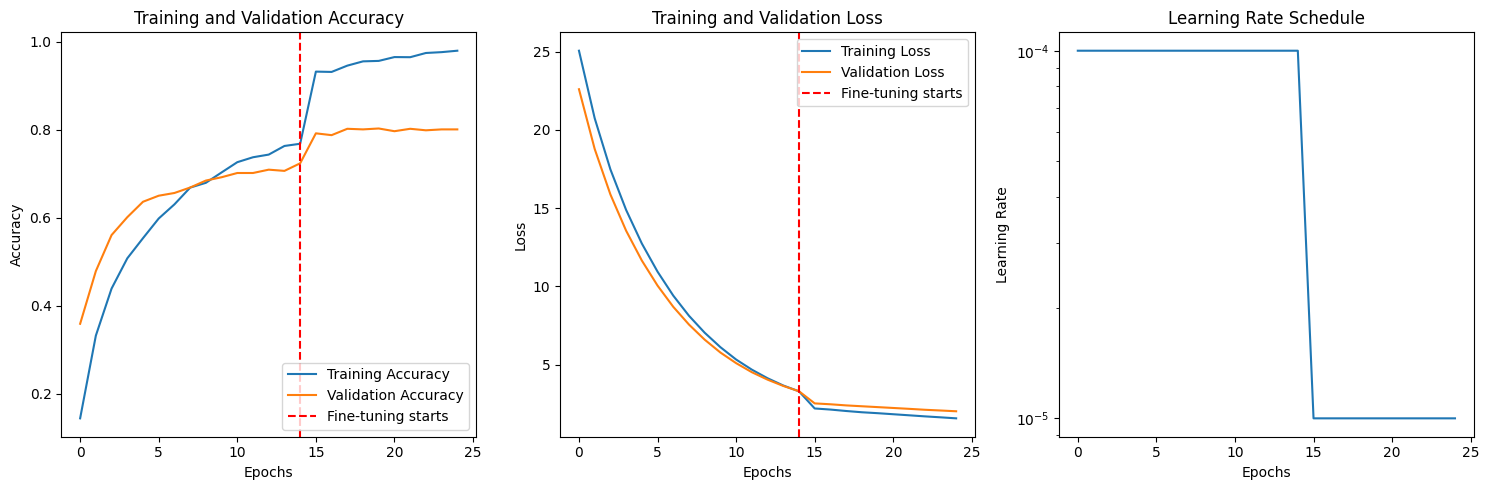

In [ ]:
def plot_training_history(history1, history2):
    # Combine histories
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=len(history1.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tuning starts')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=len(history1.history['loss'])-1, color='r', linestyle='--', label='Fine-tuning starts')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 3)
    lr_schedule = [1e-4] * len(history1.history['accuracy']) + [1e-5] * len(history2.history['accuracy'])
    plt.plot(epochs_range, lr_schedule)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

plot_training_history(history1, history2)

## 9. Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

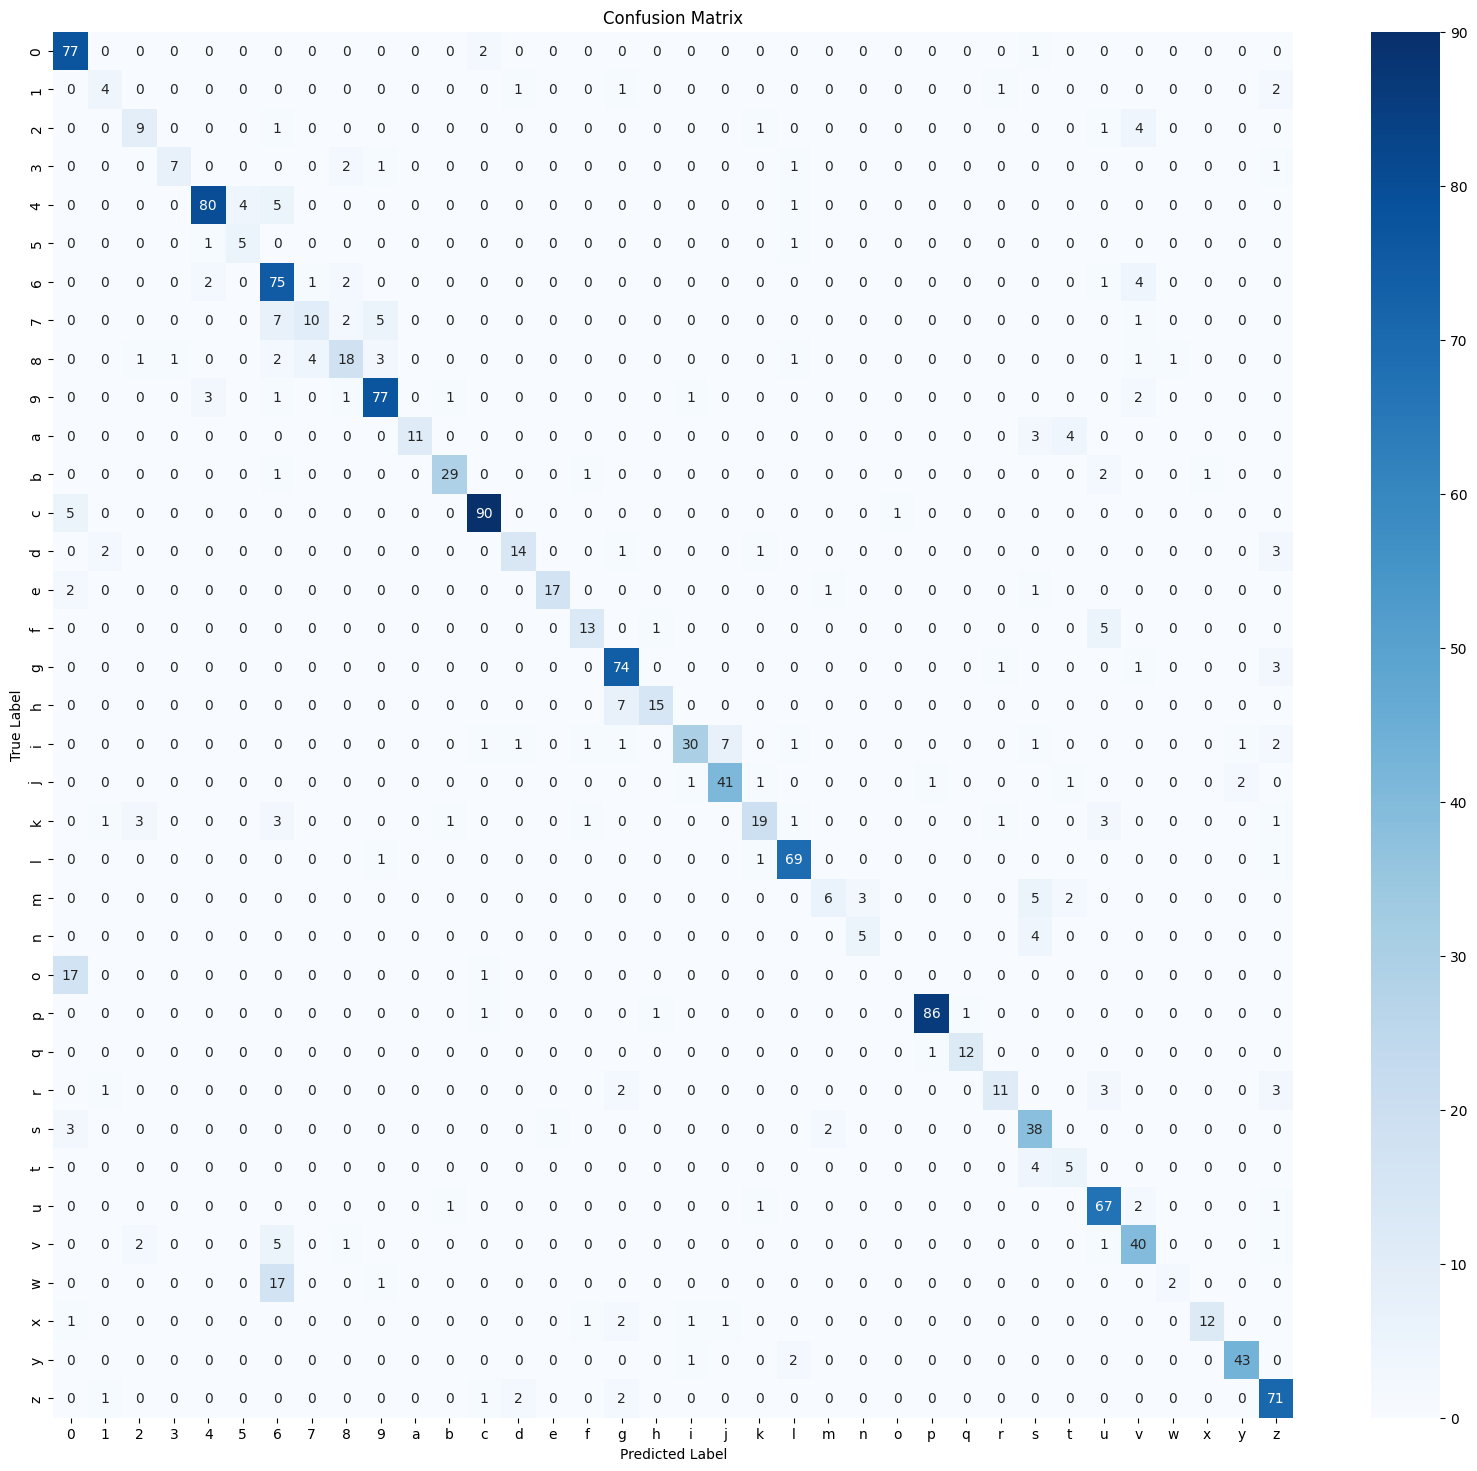

In [ ]:
# Get true labels and predictions for the test set
test_labels_flat = []
test_predictions_flat = []

for images, labels in test_ds:
    test_labels_flat.extend(labels.numpy())
    predictions = model.predict(images)
    test_predictions_flat.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(test_labels_flat, test_predictions_flat)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()